<table>
<tr><td><img style="height: 150px;" src="images/geo_hydro1.jpg"></td>
<td bgcolor="#FFFFFF">
    <p style="font-size: xx-large; font-weight: 900; line-height: 100%">AG Dynamics of the Earth</p>
    <p style="font-size: large; color: rgba(0,0,0,0.5);">Jupyter notebooks</p>
    <p style="font-size: large; color: rgba(0,0,0,0.5);">Georg Kaufmann</p>
    </td>
</tr>
</table>

# Ice-age dynamics: 9. Landscape
## Flexure (load)
----
*Georg Kaufmann,
Geophysics Section,
Institute of Geological Sciences,
Freie Universität Berlin,
Germany*

In this notebook, we model **flexure** with the **thin-plate equation**.

We first initialize the `python` libraries.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets

## Model

The flexure $w$  is modelled as thin-plate equation, 
thus the change depends on the second spatial derivative of the elevation, $\nabla^2 h$.

$$
\begin{array}{rcl}
  D \left( \frac{\partial^4 w}{\partial x^4} \right)_{flexure} & = & \rho g h 
\end{array}
$$

The **flexural rigidity** $D$ controls the flexure response:
$$
D = \frac{\displaystyle E h_p^3}{\displaystyle 12(1-\nu^2)}
$$
with the **Young modulus** $E$ [Pa] defined as:
$$
E = 2 \mu (1+\nu)
$$

| variable       | name            |unit       |
|----------------|-----------------|-----------|
| $w$            | flexure         | [m]       |
| $h$            | surface         | [m]       |
| $x$            | profile         | [x]       |
| **Lithology**    | -               | -         |
| $h_p$          | Plate thickness | [m]       |
| $\rho_c$          | crustal density | [kg/m$^3$]       |
| $\rho_m$          | mantle density | [kg/m$^3$]       |
| $\mu$          | shear modulus | [Pa]       |
| $\nu$          | Poisson ratio | [-]       |
| $D$     | flex. rigidity         | [Pa m$^3$]|

In [119]:
g          = 9.81e0          # m/s^2       ! grav. acceleration
rhocrust   = 2750e0          # kg/m^3      ! crustal density [kg/m^3]
rhomantle  = 3300e0          # kg/m^3      ! mantle density [kg/m^3]
hplate     =  10e3           # m           ! plate thickness [m]
xmu        = 6.7e10          # Pa          ! shear modulus [Pa]
xnu        = 0.25            # -           ! Poisson ratio [-]
E          = 2.*xmu*(1.+xnu) # Pa          ! Young modulus
D          = E*hplate**3 / (12.*(1.-xnu**2)) # Pa m3 ! flexural rigidity

----
## Create grid and initial topography

Make an asymmetrical model with peak height `hmax` over a profile length `length`.

In [120]:
def flexure_init(nx=101,length=100e3,uplift=2e-3,time=1e5):
    """
    function creates an initial 1D topography (Gaussian function)
    over profile length
        length [m]    default: 100.e3  ! length of profile
        uplift [m/a]  default: 2e-3    ! uplift rate
        time [a]      default: 1e5.    ! time
    """
    x,dx  = np.linspace(0,length,nx,retstep=True)
    mu = length/2.
    sigma = length/10.
    h  = np.exp(-(x-mu)**2 / sigma**2) * uplift * time

    tsave = np.zeros(10)
    topo = np.zeros(10*nx).reshape(10,nx)
    tsave[0] = 0.
    topo[0,:] = h
    #print(tsave.shape)
    #print(topo.shape)
    return x,dx,h,tsave,topo,nx,length,uplift,time

In [121]:
x,dx,h,tsave,topo,nx,length,uplift,time = flexure_init(time=5e5)

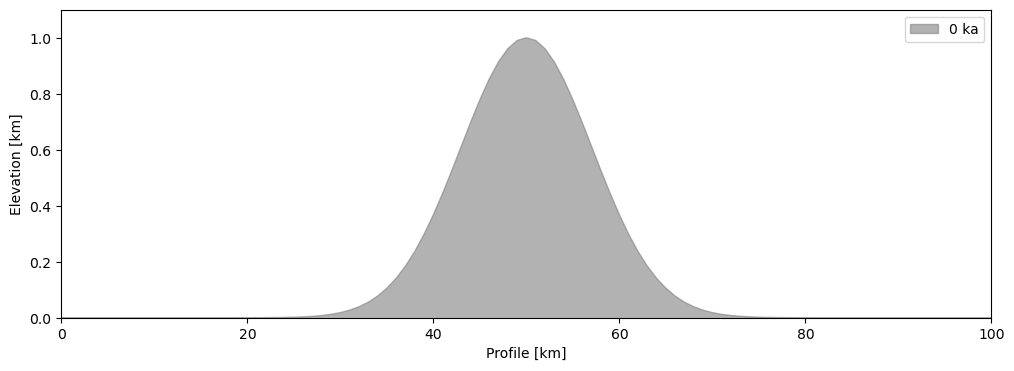

In [122]:
fig,axs = plt.subplots(1,1,figsize=(12,4))
axs.set_xlim([0,length/1000])
axs.set_ylim([0,1.1])
axs.set_xlabel('Profile [km]')
axs.set_ylabel('Elevation [km]')
axs.fill_between(x/1000,-10,topo[0,:]/1000,color='gray',alpha=0.6,label=str(int(tsave[0]/1000))+' ka')
axs.legend()

----
## Flexure
Calculate **flexure** $w$ [m] with the following steps:

- Calculate **Fourier-transform** ${\cal F}$ from elevation profile $f(x)$
$$
F(k_x) = {\cal F}[f(x)]
$$
Here $k_x$ [1/m] is the **wave number**

- Calculate **flexural  model** as **Filter** in Fourier-domain
$$
F_{flex} = \frac{\displaystyle 1}{\displaystyle (\rho_m - \rho_c)g + D k_x^4}
$$

- Multiply Fourier-transformed model with filter
$$
W(k_x) = F(k_x) F_{flex}
$$

- Apply **inverse Fourier transform**
$$
w(x) = {\cal F}^{-1} [W(k_x)]
$$

In [123]:
x,dx,h,tsave,topo,nx,length,uplift,time = flexure_init(time=5e5)

kx     = (-nx/2 + np.arange(0,nx))*2*np.pi/(x.max()-x.min())
F = np.fft.fft(rhocrust*g*h)
Fflex = 1. / ((rhomantle-rhocrust)*g + D*kx**4)
W = -np.fft.ifft(F*np.fft.fftshift(Fflex)).real 

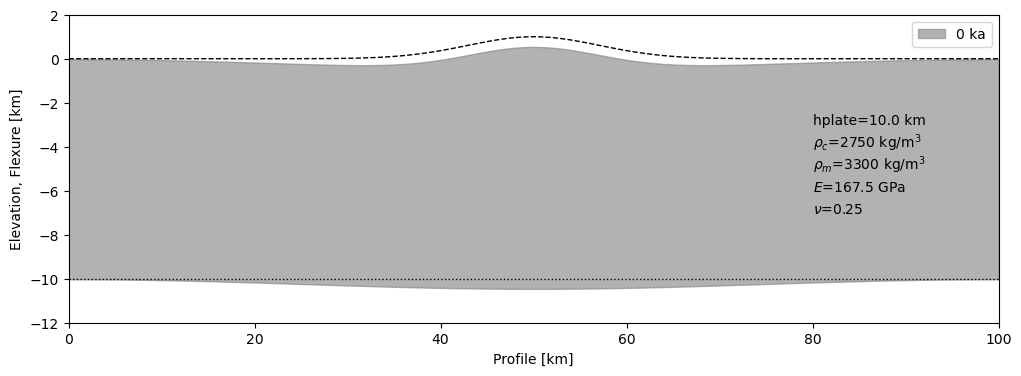

In [141]:
fig,axs = plt.subplots(1,1,figsize=(12,4))
axs.set_xlim([0,length/1000])
axs.set_ylim([-12,2])
axs.set_xlabel('Profile [km]')
axs.set_ylabel('Elevation, Flexure [km]')
axs.plot(x/1000,(topo[0,:])/1000,color='black',lw=1,ls='dashed')
axs.plot(x/1000,-hplate*np.ones_like(x)/1000,color='black',lw=1,ls='dotted')
axs.fill_between(x/1000,(W-hplate)/1000,(topo[0,:]+W)/1000,color='gray',alpha=0.6,label=str(int(tsave[0]/1000))+' ka')
axs.text(80,-3,'hplate='+str(hplate/1000)+' km')
axs.text(80,-4,'$\\rho_c$='+str(int(rhocrust))+' kg/m$^3$')
axs.text(80,-5,'$\\rho_m$='+str(int(rhomantle))+' kg/m$^3$')
axs.text(80,-6,'$E$='+str(E/1e9)+' GPa')
axs.text(80,-7,'$\\nu$='+str(xnu)+' ')
axs.legend()

... done